In [61]:
!pip install numba
from numba import cuda
import numpy as np
import time

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [62]:
@cuda.jit
def grayscale_kernel_2d(src, dst):
    x, y = cuda.grid(2)

    if y < src.shape[0] and x < src.shape[1]:
        r = float(src[y, x, 0])
        g = float(src[y, x, 1])
        b = float(src[y, x, 2])

        gray_val = float((r + g + b) / 3.0)
        dst[y, x] = gray_val


def grayscale_gpu_2d(src, block_dim):
    print(f"shape = {src.shape}")
    H, W, _ = src.shape
    grid_w = (W + block_dim[0] - 1) // block_dim[0]
    grid_h = (H + block_dim[1] - 1) // block_dim[1]
    grid_dim = (grid_w, grid_h)

    d_src = cuda.to_device(src)
    d_dst = cuda.device_array((H, W))

    start = time.time()
    grayscale_kernel_2d[grid_dim, block_dim](d_src, d_dst)
    cuda.synchronize()
    end = time.time()

    elapsed_time = end - start
    print(f"GPU 2D with {block_dim} run in {elapsed_time:.4f}s")

    return d_dst.copy_to_host(), elapsed_time

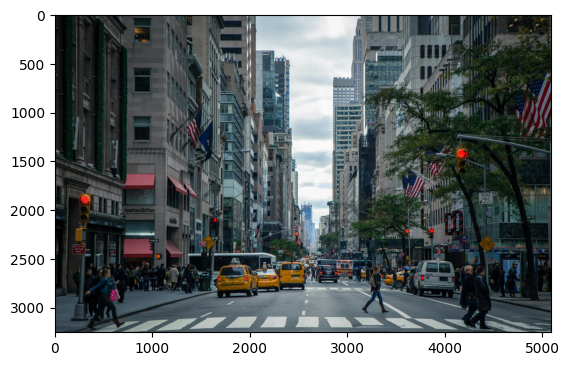

In [63]:
from matplotlib import pyplot as plt


image = plt.imread("img2.jpg")

plt.figure()
plt.imshow(image)
plt.show()

shape = (3253, 5088, 3)
GPU 2D with (32, 32) run in 0.2235s


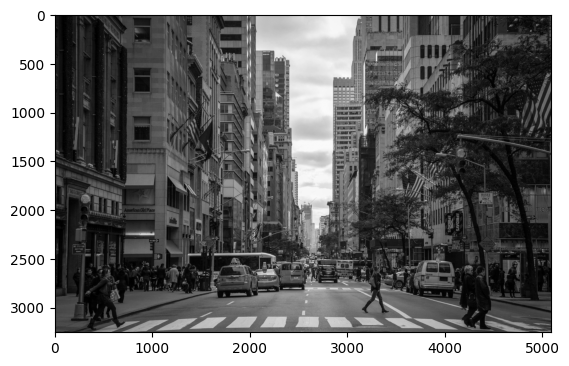

In [64]:
gray, _ = grayscale_gpu_2d(image, (32, 32))
plt.figure()
plt.imshow(gray, cmap='gray')
plt.show()

In [65]:
@cuda.jit
def binarize(input_img, output_img, threshold):
    x, y = cuda.grid(2)

    if x < input_img.shape[0] and y < input_img.shape[1]:
        # Access the pixel value directly since it's a grayscale image
        pixel = input_img[x, y]

        if pixel < threshold:
            output_img[x, y] = 0
        else:
            output_img[x, y] = 255

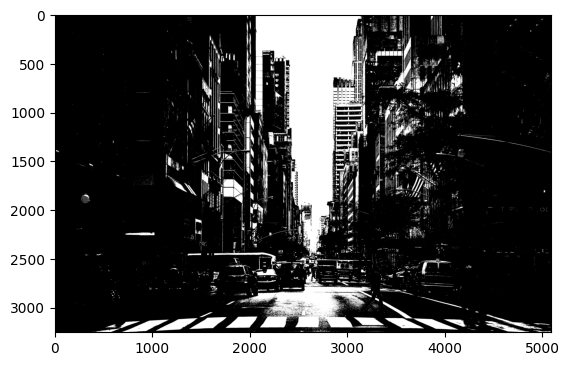

In [66]:
import math

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(gray.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(gray.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

threshold = 128
d_src = cuda.to_device(gray)
d_dst = cuda.device_array_like(d_src)

binarize[blocks_per_grid, threads_per_block](d_src, d_dst, threshold)

result = d_dst.copy_to_host()

plt.figure()
plt.imshow(result, cmap='gray')
plt.show()

6b

In [67]:
@cuda.jit
def adjust_brightness_kernel(src, dst, brightness):
  x, y = cuda.grid(2)

  if x < src.shape[0] and y < src.shape[1]:
    pixel = src[x, y]
    new_value = pixel + brightness

    new_value = min(255, max(0, new_value))
    dst[x, y] = new_value

def adjust_brightness_gpu(src, brightness):
    d_src = cuda.to_device(src)
    d_dst = cuda.device_array_like(d_src)

    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(src.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(src.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)


    adjust_brightness_kernel[blocks_per_grid, threads_per_block](d_src, d_dst, brightness)

    return d_dst.copy_to_host()

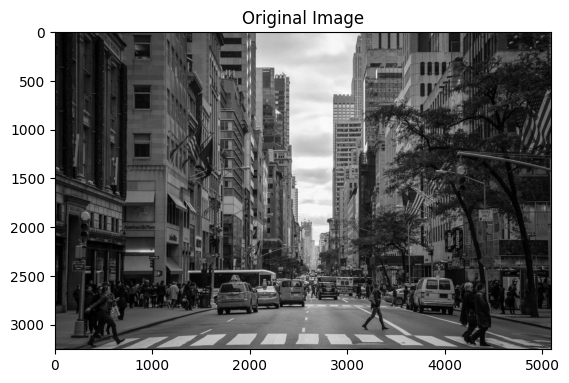

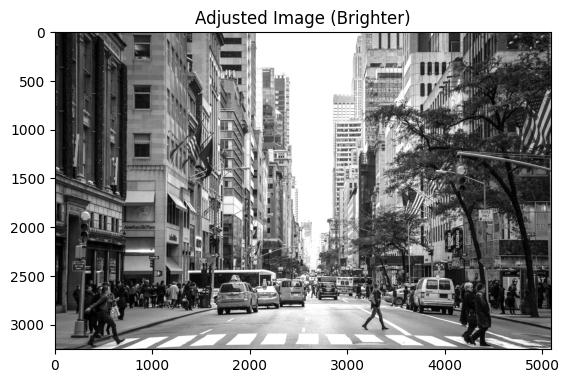

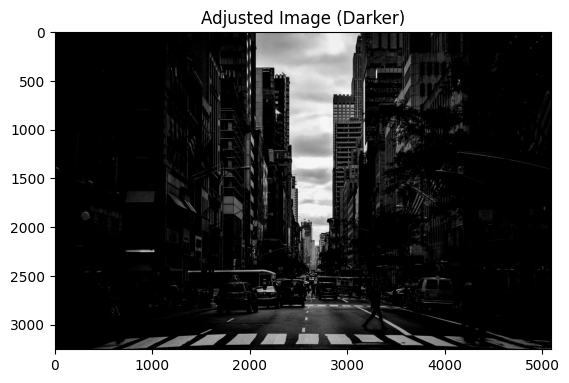

In [68]:
import math

# Display original image
plt.figure()
plt.imshow(gray, cmap='gray')
plt.title("Original Image")
plt.show()


adjusted_image = adjust_brightness_gpu(gray, 100)
plt.figure()
plt.imshow(adjusted_image, cmap='gray')
plt.title("Adjusted Image (Brighter)")
plt.show()

adjust_image_darker = adjust_brightness_gpu(gray, -100)
plt.figure()
plt.imshow(adjust_image_darker, cmap='gray')
plt.title("Adjusted Image (Darker)")
plt.show()

6c

In [69]:
!pip install Pillow

In [70]:
from PIL import Image

def resize_image(image_path, new_width, new_height):
  try:
    img = Image.open(image_path)
    resized_img = img.resize((new_width, new_height))
    return resized_img
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None
  except Exception as e:
    print(f"An error occurred during resizing: {e}")
    return None

car_image_path = "car.png"  # Make sure you have car.png in your environment
plane_image_path = "plane.png" # Make sure you have plane.png in your environment

new_width = 1920
new_height = 1280

resized_car = resize_image(car_image_path, new_width, new_height)
resized_plane = resize_image(plane_image_path, new_width, new_height)

if resized_car:
    print(f"Resized car image shape: {resized_car.size}")
    # Save the resized image
    resized_car.save("resized_car.png")

if resized_plane:
    print(f"Resized plane image shape: {resized_plane.size}")
    # Save the resized image
    resized_plane.save("resized_plane.png")

Resized car image shape: (1920, 1280)
Resized plane image shape: (1920, 1280)


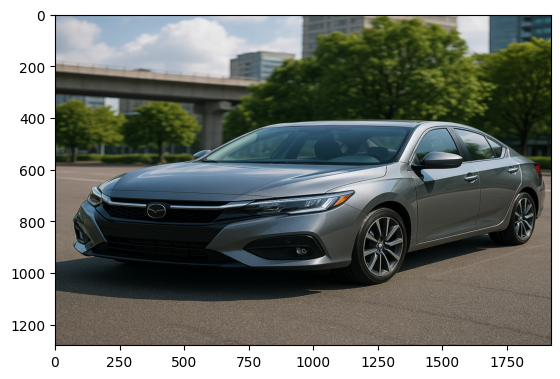

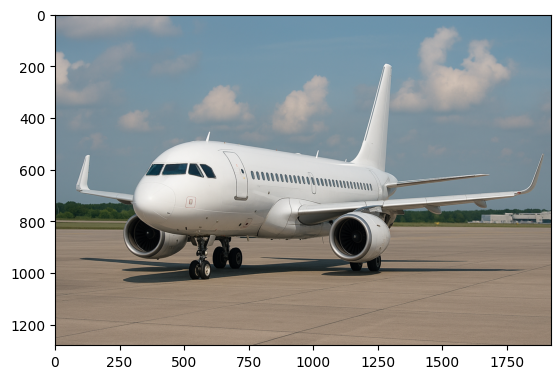

YES I USE LLM TO GEN THIS CCODE TO SAVE TIME


In [71]:
loaded_resized_car = plt.imread("resized_car.png")
loaded_resized_plane = plt.imread("resized_plane.png")

plt.figure()
plt.imshow(loaded_resized_car)
plt.show()

plt.figure()
plt.imshow(loaded_resized_plane)
plt.show()

print("YES I USE LLM TO GEN THIS CCODE TO SAVE TIME")

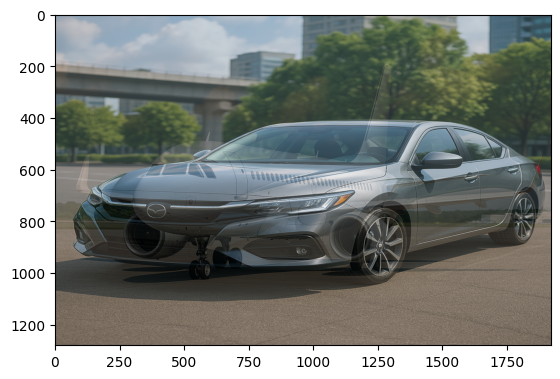

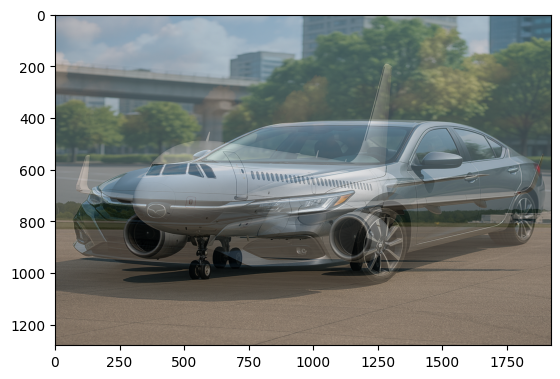

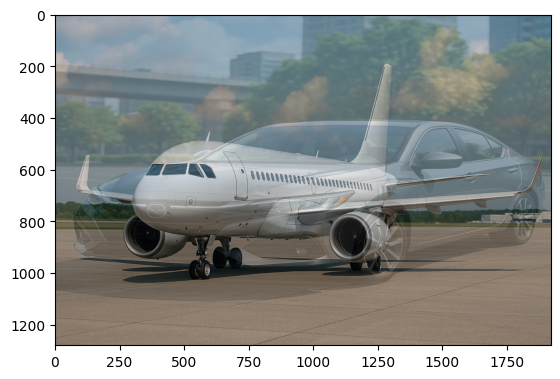

In [73]:
@cuda.jit
def blend(src1, src2, dst, weight):
  x, y = cuda.grid(2)

  # Corrected boundary check using .shape
  if x < src1.shape[0] and y < src1.shape[1]:
    for c in range(src1.shape[2]): # Iterate over color channels
      # Perform blending with float values
      blended_value = weight * src1[x, y, c] + (1 - weight) * src2[x, y, c]
      # Clamp the value to the range [0.0, 1.0] and assign to destination
      dst[x, y, c] = max(0.0, min(1.0, blended_value))


def blend_images(image_1, image_2, weight):
  # Ensure images are numpy arrays and have compatible shapes and types
  if not isinstance(image_1, np.ndarray):
      image_1 = np.array(image_1)
  if not isinstance(image_2, np.ndarray):
      image_2 = np.array(image_2)

  if image_1.shape != image_2.shape:
      raise ValueError("Input images must have the same dimensions for blending.")

  if image_1.dtype != np.float32 or image_1.max() > 1.0 or image_1.min() < 0.0:
      image_1 = image_1.astype(np.float32)

  if image_2.dtype != np.float32 or image_2.max() > 1.0 or image_2.min() < 0.0:
      image_2 = image_2.astype(np.float32)

  d_src1 = cuda.to_device(image_1)
  d_src2 = cuda.to_device(image_2)
  d_dst = cuda.device_array_like(d_src1)

  threads_per_block = (16, 16)

  blocks_per_grid_x = math.ceil(image_1.shape[0] / threads_per_block[0])
  blocks_per_grid_y = math.ceil(image_1.shape[1] / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  blend[blocks_per_grid, threads_per_block](d_src1, d_src2, d_dst, weight)

  result_img = d_dst.copy_to_host()
  if result_img.max() <= 1.0:
      result_img = (result_img * 255).astype(np.uint8)

  return result_img

plt.figure()
plt.imshow(blend_images(np.array(loaded_resized_car), np.array(loaded_resized_plane), 0.7))
plt.show()
plt.imshow(blend_images(np.array(loaded_resized_car), np.array(loaded_resized_plane), 0.5))
plt.show()
plt.imshow(blend_images(np.array(loaded_resized_car), np.array(loaded_resized_plane), 0.3))
plt.show()
